In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
dataset_dir = '/Data/Dataset/Waymo/V1_2_tf/validation_interactive_extracted'
ckpt_path = '../weights/VBD_log_50_1_0.15_v2/epoch=19.ckpt'
anchor_path = '../vbd/data/cluster_64_center_dict.pkl'

# Generating Traffic Scenarios without Guidance
This notebook is a simple example of how to generate traffic scenarios without guidance. 

In [3]:
## Import Dependencies
import torch
import numpy as np
from vbd.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
import mediapy
import matplotlib.pyplot as plt


## Set Environment
env_config = EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
)

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay = True,
)

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset

dataset = WaymaxTestDataset(
    data_dir = dataset_dir,
    anchor_path = anchor_path,
)

# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
model = VBDTest.load_from_checkpoint(ckpt_path,map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()
print("Load from: ", ckpt_path)
A = 32
model.reset_agent_length(A)
dataset.max_object  = A

I0000 00:00:1769164412.794179 1393129 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


    Scanning directory: /Data/Dataset/Waymo/V1_2_tf/validation_interactive_extracted
    Found 0 files
    Loading anchors from: ../vbd/data/cluster_64_center_dict.pkl
    Dataset ready!


FileNotFoundError: [Errno 2] No such file or directory: '/home/anthony/VBD/example/../weights/VBD_log_50_1_0.15_v2/epoch=19.ckpt'

In [4]:
dataset_dir = '/mnt/d/WaymoMotionV1_2/val_processed/processed/'
ckpt_path = '/home/anthony/VBD/train_log/FlowMatching_20260122121321/epoch=15.ckpt'
anchor_path = '../vbd/data/cluster_64_center_dict.pkl'
cfg_path = '/home/anthony/VBD/config/FlowMatching.yaml'

In [5]:
## Import Dependencies
import torch
import numpy as np
from vbd.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
import mediapy
import matplotlib.pyplot as plt

## Set Environment
env_config = EnvironmentConfig(
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
 )

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay=True,
 )

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset
dataset = WaymaxTestDataset(
    data_dir=dataset_dir,
    anchor_path=anchor_path,
 )

# Load FlowMatching model
from omegaconf import OmegaConf
from vbd.model.FlowMatching import FlowMatching
from vbd.sim_agent.sim_actor import sample_to_action

cfg = OmegaConf.load(cfg_path)
model = FlowMatching(cfg)
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)

_ = model.cuda()
_ = model.eval()
print("Load from: ", ckpt_path)

A = 32
dataset.max_object = A

# Example: sample one scenario (open-loop sampling)
i = np.random.randint(len(dataset))
scenario_id, scenario, _ = dataset.get_scenario_by_index(i)
mediapy.show_image(plot_state(scenario, log_traj=True))
print(scenario_id)

sample = dataset.process_scenario(
    scenario,
    current_index=10,
    use_log=True,
    remove_history=False,
 )
batch = dataset.__collate_fn__([sample])
batch = {k: (v.cuda() if torch.is_tensor(v) else v) for k, v in batch.items()}

with torch.no_grad():
    pred = model.sample_actions(
        batch,
        num_steps=50,
        method="euler",
    )

# pred["trajs"]: [1, A, 80, 5], pred["actions"]: [1, A, 16, 2]
trajs = pred["trajs"].cpu().numpy()[0]

    Scanning directory: /mnt/d/WaymoMotionV1_2/val_processed/processed/
    Found 44097 files
    Loading anchors from: ../vbd/data/cluster_64_center_dict.pkl
    Dataset ready!


FileNotFoundError: [Errno 2] No such file or directory: '/home/anthony/VBD/train_log/FlowMatching_20260122121321/epoch=15.ckpt'

## Load one scenario and visualize the log replay

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


""

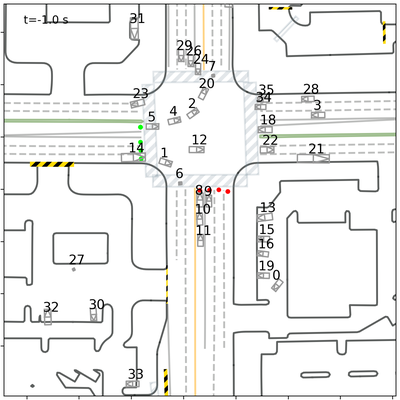

1f095318b68ba09d


In [6]:
i = np.random.randint(len(dataset))
scenario_id, scenario, _ = dataset.get_scenario_by_index(i)
mediapy.show_image(plot_state(scenario, log_traj=True))
print(scenario_id)

## Closed Loop Roll Out

In [7]:
model.cuda()
replan_freq=10 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None
remove_history = False

In [26]:
init_state = env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=True,
  remove_history=remove_history
)

is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

# x_t = torch.randn(1, A, 40, 2, device=model.device)
x_t = torch.zeros(1, A, 40, 2, device=model.device)


for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=i==0,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
          remove_history=remove_history
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch, x_t=x_t)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    
    action = sample_to_action(action_sample, is_controlled, agents_id= selected_agents)

    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Replan at  10


AttributeError: 'FlowMatching' object has no attribute 'sample_denoiser'

In [8]:
dataset_dir = '/mnt/d/WaymoMotionV1_2/val_processed/processed/'
ckpt_path = '/home/anthony/VBD/train_log/FlowMatching_20260123181821/epoch=01.ckpt'
anchor_path = '../vbd/data/cluster_64_center_dict.pkl'
cfg_path = '/home/anthony/VBD/config/FlowMatching.yaml'

In [9]:
init_state = env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=True,
  remove_history=remove_history
)

is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

device = next(model.parameters()).device

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=i==0,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
          remove_history=remove_history
        )
        batch = dataset.__collate_fn__([sample])
        batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}
        pred = model.sample_actions(
            batch,
            num_steps=50,
            method="euler",
        )
        traj_pred = pred['trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    
    action = sample_to_action(action_sample, is_controlled, agents_id= selected_agents)

    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

[ 1  2  4  5  6  8  9 10 11 12 13 14 15 16 17 18]
Replan at  10


RuntimeError: shape '[-1, 32, 16, 5, 5]' is invalid for input of size 6400

## Generate Video

In [ ]:
imgs = [plot_state(state, log_traj=False) for state in state_logs]
mediapy.show_video(imgs, fps=10)

: 